# Test ASDETECT Run Environment

## Classic ASDETECT (no numba)

In [6]:
import numpy as np
import numba
import timeit

import toad
from toad.shifts_detection.methods.asdetect import ASDETECT

### Show Function

In [31]:
fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()

td1.compute_shifts("thk", ASDETECT(), overwrite=True)

shifts1 = td1.get_shifts("thk")
mean1 = shifts1.mean().values
std1 = shifts1.std().values

print(f"Mean: {mean1}")
print(f"Std: {std1}")

Mean: -0.08923333883285522
Std: 0.23308858275413513


In [32]:
# from sklearn.cluster import HDBSCAN  Could use the one from sklearn, but below is faster
from fast_hdbscan import HDBSCAN

# Minimum required input is a variable name, a method and a filtering function.
td1.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x)
    > 0.8,  # toad will cluster the points that pass this filter
)


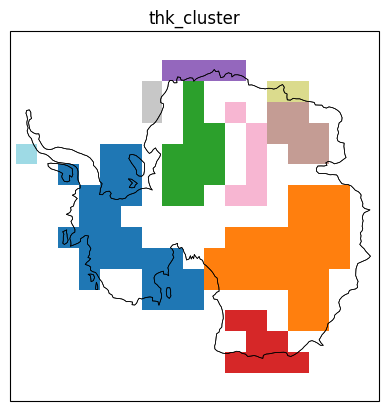

In [33]:
fig, ax = td1.plotter().south_pole_plots(grid_labels=False)
td1.plotter().plot_clusters_on_map(
    "thk", ax=ax, cluster_ids=range(10)
);  # plot 10 largest clusters

### Time It

In [7]:
setup = '''
import toad
from toad.shifts_detection.methods.asdetect import ASDETECT

fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()
'''

code = '''
td1.compute_shifts("thk", ASDETECT(), overwrite=True)
'''

iterations = 10
time = timeit.timeit(setup=setup, stmt=code, number=iterations)
print(f"Avg. Time: {time/iterations}")

Avg. Time: 10.188993433100041


## Advanced ASDETECT (with numba)

In [1]:
import numpy as np
import numba
import timeit

import toad
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba

### Show Function

In [2]:
fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()

td1.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)

shifts1 = td1.get_shifts("thk")
mean1 = shifts1.mean().values
std1 = shifts1.std().values

print(f"Mean: {mean1}")
print(f"Std: {std1}")

Mean: -0.08924668282270432
Std: 0.2330613136291504


In [3]:
# from sklearn.cluster import HDBSCAN  Could use the one from sklearn, but below is faster
from fast_hdbscan import HDBSCAN

# Minimum required input is a variable name, a method and a filtering function.
td1.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x)
    > 0.8,  # toad will cluster the points that pass this filter
)


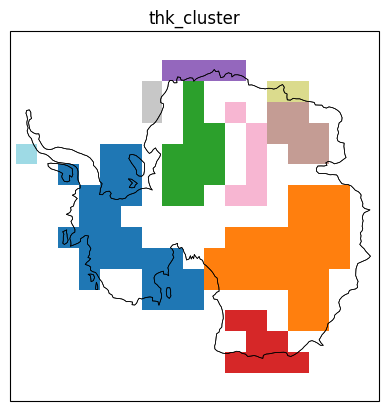

In [4]:
fig, ax = td1.plotter().south_pole_plots(grid_labels=False)
td1.plotter().plot_clusters_on_map(
    "thk", ax=ax, cluster_ids=range(10)
);  # plot 10 largest clusters

### Time It

In [8]:
setup = '''
import toad
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba

fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()
'''

code = '''
td1.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)
'''

iterations = 10
time = timeit.timeit(setup=setup, stmt=code, number=iterations)
print(f"Avg. Time: {time/iterations}")

Avg. Time: 7.632848366100006


## Numba Polyfit

In [5]:
from toad.shifts_detection.methods.polyfit_numba import polyfit
from numpy import polyfit as np_polyfit, linspace, cos, random

# Create Dummy Data and use existing numpy polyfit as test
x = linspace(0, 2, 20)   
y = cos(x) + 0.3*random.rand(20)
p = np_polyfit(x, y, 3)

t = linspace(0, 2, 200)

# Now plot using the Numba (amazing) functions
p_coeffs = polyfit(x, y, deg=3)

print(f"Original Coefficients: {p}")
print(f"Numba Coefficients: {p_coeffs}")

Original Coefficients: [ 0.38583306 -1.44944898  0.7479023   0.98758948]
Numba Coefficients: [ 0.38583306 -1.44944898  0.7479023   0.98758948]


## Test Numba Version

In [1]:
import pytest
import numpy as np
from toad import TOAD
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba
#from toad.shifts_detection.methods.asdetect import ASDETECT as ASDETECT_Numba

def test_params():
    """Fixture providing parameters for the ASDETECT test.

    Returns:
        dict: A dictionary containing:
            - lat (int): Latitude coarsening factor.
            - lon (int): Longitude coarsening factor.
            - time (int): Time coarsening factor.
            - expected_mean (float): Expected mean of the shifts.
            - expected_std (float): Expected standard deviation of the shifts.
    """
    return {
        "lat": 10,
        "lon": 10,
        "time": 3,
        "expected_mean": 0.0038361712,
        "expected_std": 0.19410655,
    }

def toad_instance():
    return TOAD("tutorials/test_data/global_mean_summer_tas.nc")


def test_asdetect(test_params, toad_instance):
    """Test the ASDETECT shift detection method.

    This test verifies the computation of shifts using the ASDETECT method
    after coarsening the data based on specified latitude, longitude, and
    time parameters. It checks that the computed mean and standard deviation
    of the shifts match the expected results.

    Args:
        test_params (dict): Parameters for the test.
        toad_instance (TOAD): Instance of TOAD containing the data.
    """
    # Setup
    td = toad_instance
    td.data = td.data.coarsen(
        lat=test_params["lat"],
        lon=test_params["lon"],
        time=test_params["time"],
        boundary="trim",
    ).mean()

    td.compute_shifts("tas", ASDETECT_Numba(), overwrite=True)

    shifts = td.get_shifts("tas")
    mean = shifts.mean().values
    std = shifts.std().values

    np.testing.assert_allclose(mean, test_params["expected_mean"], rtol=1e-5, atol=1e-8)
    np.testing.assert_allclose(std, test_params["expected_std"], rtol=1e-5, atol=1e-8)

test_asdetect(test_params(), toad_instance())

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=1e-08

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 2.63760307e-05
Max relative difference: 0.00013588
 x: array(0.19408)
 y: array(0.194107)